In [2]:
!pip install great_expectations

    PyYAML (>=5.1.*)
            ~~~~~~^


In [5]:
import great_expectations as ge
from great_expectations.dataset.pandas_dataset import PandasDataset
import pandas as pd
import IPython.display as display

In [6]:
file_path = r"C:/Users/91984/Downloads/Online Retail.xlsx"
df = pd.read_excel(file_path)

df['InvoiceDate'] = df['InvoiceDate'].dt.strftime("%Y-%m-%d %H:%M:%S")

dataset = PandasDataset(df)

In [7]:
#Custom expectations
def expect_column_values_to_match_regex(dataset, column, regex):
    result = dataset[column].astype(str).str.match(regex)
    unexpected_values = dataset[~result][column]
    return {
        "success": result.all(),
        "result": {
            "unexpected_count": len(unexpected_values),
            "unexpected_percent": len(unexpected_values) / len(dataset) * 100,
            "unexpected_values": unexpected_values.tolist()
        }
    }

def expect_column_values_to_be_in_set(dataset, column, value_set):
    result = dataset[column].isin(value_set)
    unexpected_values = dataset[~result][column]
    return {
        "success": result.all(),
        "result": {
            "unexpected_count": len(unexpected_values),
            "unexpected_percent": len(unexpected_values) / len(dataset) * 100,
            "unexpected_values": unexpected_values.tolist()
        }
    }

def expect_column_values_to_contain_substring(dataset, column, substring_list):
    result = dataset[column].astype(str).apply(lambda x: any(sub in x for sub in substring_list))
    unexpected_values = dataset[~result][column]
    return {
        "success": result.all(),
        "result": {
            "unexpected_count": len(unexpected_values),
            "unexpected_percent": len(unexpected_values) / len(dataset) * 100,
            "unexpected_values": unexpected_values.tolist()
        }
    }

def expect_column_values_to_be_greater_than(dataset, column, value):
    result = dataset[column] > value
    unexpected_values = dataset[~result][column]
    return {
        "success": result.all(),
        "result": {
            "unexpected_count": len(unexpected_values),
            "unexpected_percent": len(unexpected_values) / len(dataset) * 100,
            "unexpected_values": unexpected_values.tolist()
        }
    }

def expect_column_values_to_be_between(dataset, column, min_value, max_value):
    result = dataset[column].between(min_value, max_value)
    unexpected_values = dataset[~result][column]
    return {
        "success": result.all(),
        "result": {
            "unexpected_count": len(unexpected_values),
            "unexpected_percent": len(unexpected_values) / len(dataset) * 100,
            "unexpected_values": unexpected_values.tolist()
        }
    }
#Assigning expectations to respective columns
expectations = [
    # InvoiceNo expectations
    {"expectation": expect_column_values_to_match_regex, "kwargs": {"column": "InvoiceNo", "regex": r"^\d+$"}},
    {"expectation": dataset.expect_column_values_to_be_unique, "kwargs": {"column": "InvoiceNo"}},

    # StockCode expectations
    {"expectation": expect_column_values_to_match_regex, "kwargs": {"column": "StockCode", "regex": r"^[A-Za-z0-9]+$"}},
    {"expectation": dataset.expect_column_values_to_not_be_null, "kwargs": {"column": "StockCode"}},

    # Description expectations
    {"expectation": dataset.expect_column_values_to_not_be_null, "kwargs": {"column": "Description"}},
    {"expectation": expect_column_values_to_contain_substring, "kwargs": {"column": "Description", "substring_list": ["product", "set", "item"]}},

    # Quantity expectations
    {"expectation": expect_column_values_to_be_greater_than, "kwargs": {"column": "Quantity", "value": 0}},
    {"expectation": expect_column_values_to_be_between, "kwargs": {"column": "Quantity", "min_value": 1, "max_value": 10000}},

    # InvoiceDate expectations
    {"expectation": dataset.expect_column_values_to_match_strftime_format, "kwargs": {"column": "InvoiceDate", "strftime_format": "%Y-%m-%d %H:%M:%S"}},
    {"expectation": expect_column_values_to_be_between, "kwargs": {"column": "InvoiceDate", "min_value": "2010-01-01 00:00:00", "max_value": "2012-12-31 23:59:59"}},

    # UnitPrice expectations
    {"expectation": expect_column_values_to_be_greater_than, "kwargs": {"column": "UnitPrice", "value": 0}},
    {"expectation": expect_column_values_to_be_between, "kwargs": {"column": "UnitPrice", "min_value": 0.01, "max_value": 1000}},

    # CustomerID expectations
    {"expectation": dataset.expect_column_values_to_not_be_null, "kwargs": {"column": "CustomerID"}},
    {"expectation": expect_column_values_to_be_between, "kwargs": {"column": "CustomerID", "min_value": 10000, "max_value": 99999}},

    # Country expectations
    {"expectation": dataset.expect_column_values_to_not_be_null, "kwargs": {"column": "Country"}},
    {"expectation": expect_column_values_to_be_in_set, "kwargs": {"column": "Country", "value_set": ["United Kingdom", "Germany", "France", "EIRE", "Spain", "Netherlands", "Belgium", "Switzerland", "Portugal", "Australia", "Sweden", "Austria", "Norway", "Denmark", "Finland", "Italy", "Cyprus", "Greece", "Japan", "United Arab Emirates", "RSA", "Singapore", "Lebanon", "Brazil", "USA", "Canada", "Unspecified"]}}
]


results = []
for exp in expectations:
    if exp["expectation"] in [expect_column_values_to_match_regex, expect_column_values_to_be_in_set, expect_column_values_to_contain_substring, expect_column_values_to_be_greater_than, expect_column_values_to_be_between]:
        result = exp["expectation"](dataset, **exp["kwargs"])
    else:
        expectation = exp["expectation"]
        result = expectation(**exp["kwargs"])
    
    unexpected_count = result["result"].get("unexpected_count", 0)
    total_count = len(dataset)
    expected_count = total_count - unexpected_count
    unexpected_percent = int(result["result"].get("unexpected_percent", 0))
    
    details = []
    if "regex" in exp["kwargs"]:
        details.append(f"Values must match regex: {exp['kwargs']['regex']}")
    if "value_set" in exp["kwargs"]:
        details.append(f"Values must be one of: {', '.join(exp['kwargs']['value_set'])}")
    if "substring_list" in exp["kwargs"]:
        details.append(f"Values must contain one of: {', '.join(exp['kwargs']['substring_list'])}")
    if "min_value" in exp["kwargs"] and "max_value" in exp["kwargs"]:
        details.append(f"Values must be between {exp['kwargs']['min_value']} and {exp['kwargs']['max_value']}")
    if "min_value" in exp["kwargs"]:
        details.append(f"Values must be greater than {exp['kwargs']['min_value']}")
    if "strftime_format" in exp["kwargs"]:
        details.append(f"Values must match date format: {exp['kwargs']['strftime_format']}")
    
    details_str = "; ".join(details)
    
    status = "Good" if 0 <= unexpected_percent <= 50 else "Critical" if 51 <= unexpected_percent <= 100 else "Unknown"
    
    results.append({
        "Expectation": exp["expectation"].__name__,
        "Column": exp["kwargs"].get("column"),
        "Rules applied": details_str,
        "Success": result["success"],
        "Unexpected Count": unexpected_count,
        "Unexpected Percent": f"{unexpected_percent}%",
        "Status": status,
        "Expected Count": expected_count,
        "Expected Percent": f"{100 - unexpected_percent}%"
      
    })

results_df = pd.DataFrame(results)

# Replace NaN with 0 in the results DataFrame
results_df.fillna(0, inplace=True)

#print(results_df)

display.display(results_df)


,Expectation,Column,Rules applied,Success,Unexpected Count,Unexpected Percent,Status,Expected Count,Expected Percent
0,expect_column_values_to_match_regex,InvoiceNo,Values must match regex: ^\d+$,False,9291,1%,Good,532618,99%
1,expect_column_values_to_be_unique,InvoiceNo,,False,536068,98%,Critical,5841,2%
2,expect_column_values_to_match_regex,StockCode,Values must match regex: ^[A-Za-z0-9]+$,False,71,0%,Good,541838,100%
3,expect_column_values_to_not_be_null,StockCode,,True,0,0%,Good,541909,100%
4,expect_column_values_to_not_be_null,Description,,False,1454,0%,Good,540455,100%
5,expect_column_values_to_contain_substring,Description,"Values must contain one of: product, set, item",False,541878,99%,Critical,31,1%
6,expect_column_values_to_be_greater_than,Quantity,,False,10624,1%,Good,531285,99%
7,expect_column_values_to_be_between,Quantity,Values must be between 1 and 10000; Values mus...,False,10627,1%,Good,531282,99%
8,expect_column_values_to_match_strftime_format,InvoiceDate,Values must match date format: %Y-%m-%d %H:%M:%S,True,0,0%,Good,541909,100%
9,expect_column_values_to_be_between,InvoiceDate,Values must be between 2010-01-01 00:00:00 and...,True,0,0%,Good,541909,100%


Total Expectations: 16
Total Passed: 4
Total Failed: 12
Overall Success Rate: 25.00%


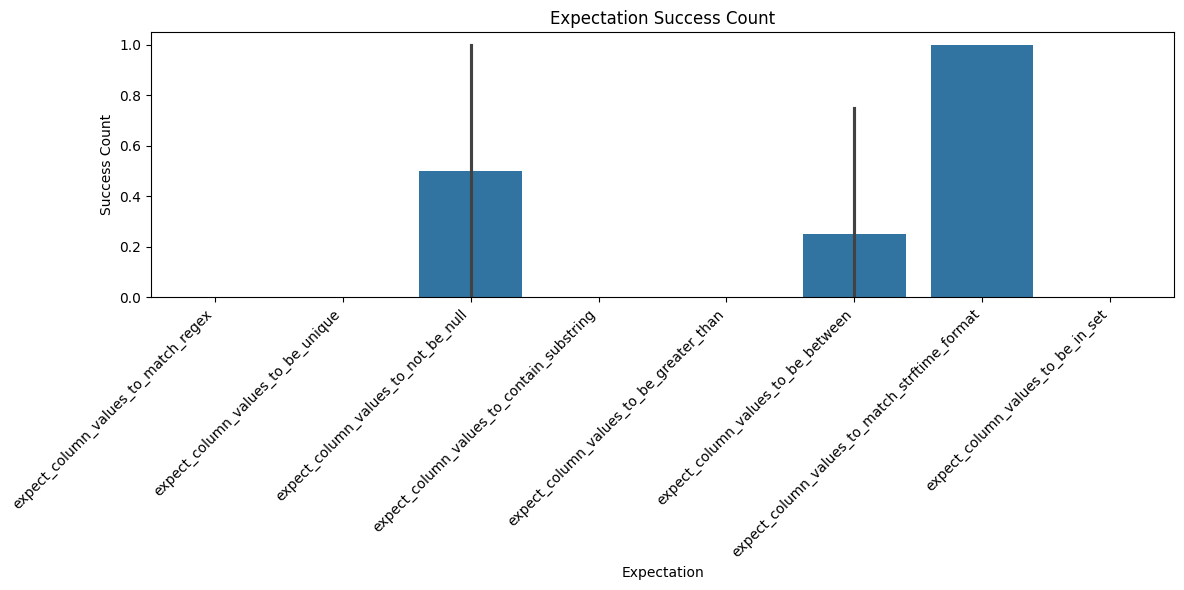

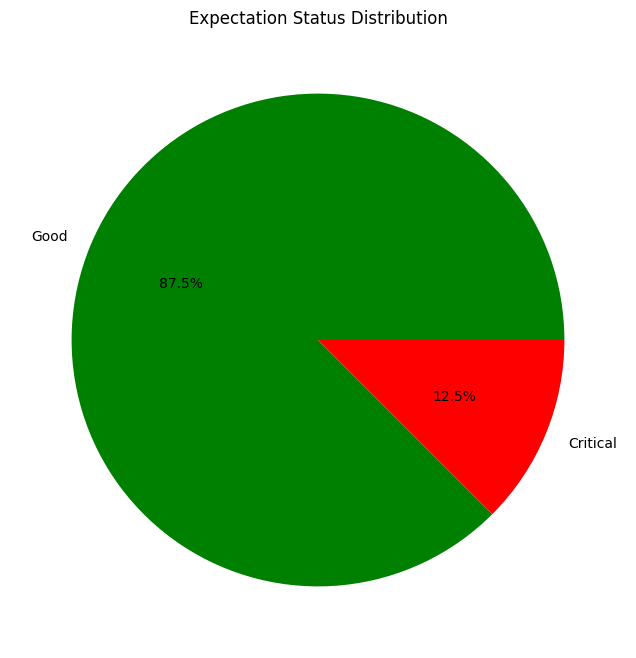

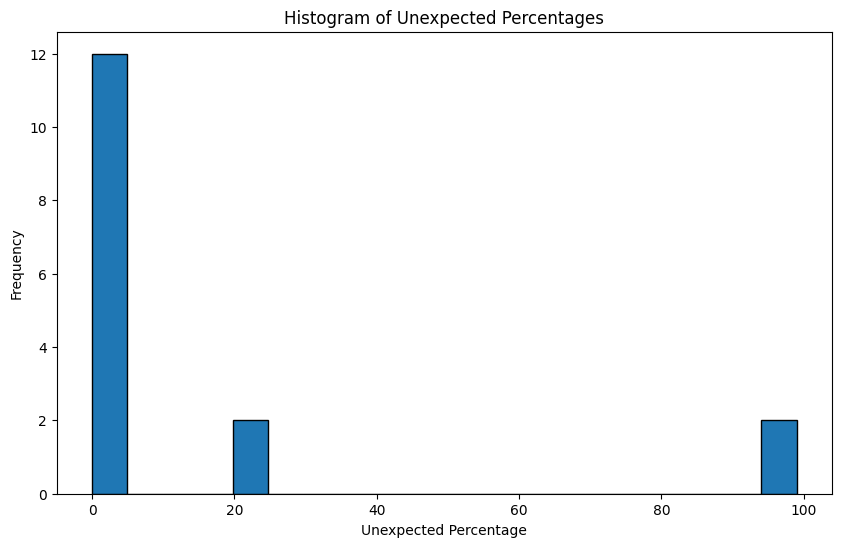

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate statistics
total_expectations = len(results_df)
total_passed = results_df['Success'].sum()
total_failed = total_expectations - total_passed
success_rate = (total_passed / total_expectations) * 100

print(f"Total Expectations: {total_expectations}")
print(f"Total Passed: {total_passed}")
print(f"Total Failed: {total_failed}")
print(f"Overall Success Rate: {success_rate:.2f}%")

# Visualization: Bar Chart of Expectations Success
plt.figure(figsize=(12, 6))
sns.barplot(x='Expectation', y='Success', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('Expectation Success Count')
plt.xlabel('Expectation')
plt.ylabel('Success Count')
plt.tight_layout()
plt.show()

# Visualization: Pie Chart of Expectation Status
status_counts = results_df['Status'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title('Expectation Status Distribution')
plt.show()

# Visualization: Histogram of Unexpected Percentages
results_df['Unexpected Percent'] = results_df['Unexpected Percent'].str.replace('%', '').astype(float)
plt.figure(figsize=(10, 6))
plt.hist(results_df['Unexpected Percent'], bins=20, edgecolor='black')
plt.title('Histogram of Unexpected Percentages')
plt.xlabel('Unexpected Percentage')
plt.ylabel('Frequency')
plt.show()

In [11]:
from scipy.stats import zscore

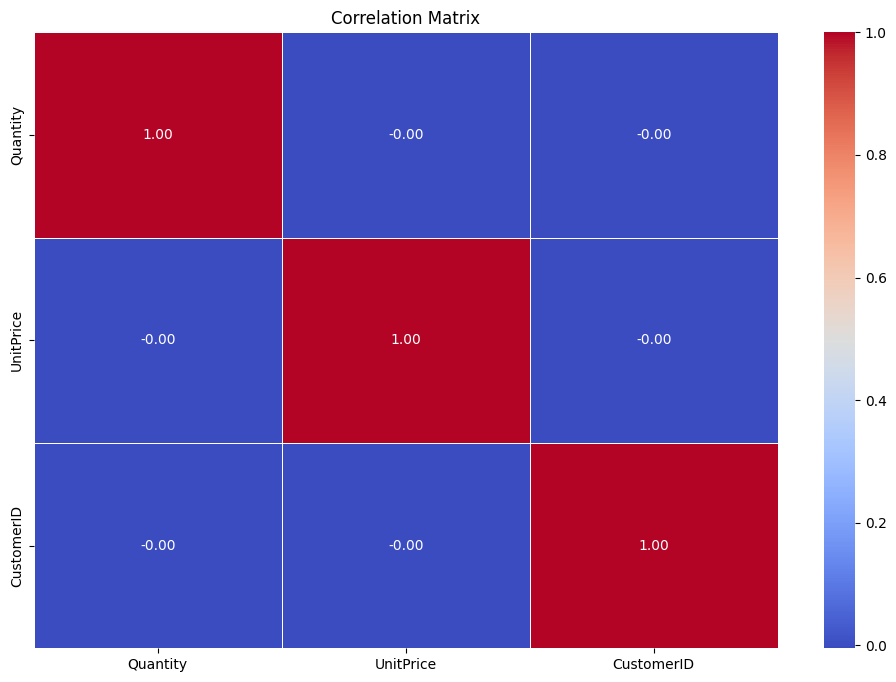

Number of anomalies detected: 720


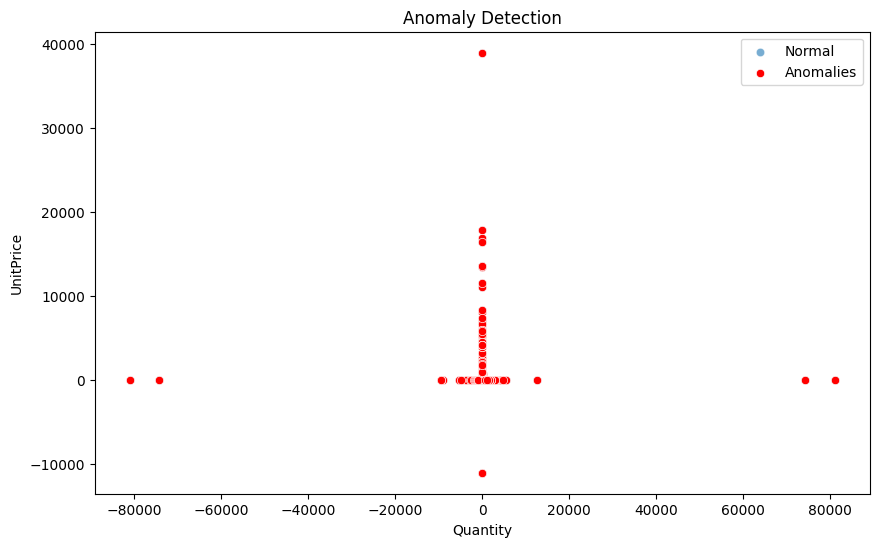

In [13]:
# Correlation Analysis
# Filter numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Anomaly Detection
numeric_df = df.select_dtypes(include=['number'])
z_scores = numeric_df.apply(zscore)
anomalies = (abs(z_scores) > 3).any(axis=1)
anomalous_data = df[anomalies]

print(f"Number of anomalies detected: {len(anomalous_data)}")

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='UnitPrice', data=df, label='Normal', alpha=0.6)
sns.scatterplot(x='Quantity', y='UnitPrice', data=anomalous_data, color='red', label='Anomalies')
plt.title('Anomaly Detection')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.legend()
plt.show()